# 10x scRNA-seq clustering analysis and annotation (CCN20230504)

A set of 781 10X scRNA-seq libraries were generated from anatomically defined tissue microdissections in adult mouse brains, resulting in a dataset of ~7.0 million single-cell transcriptomes. An iterative clustering analysis (scrattch.bigcat package) was conducted on ~4.3 milion QC-qualified cells resulting 5,283 clusters. The clusters where then computationally grouped into ~307 subclasses. A detailed analysis of all the subclasses and clusters was conducted. During this process, low quality noisy clusters (usally doublets or mixed debris) were identified and removed resulting a final set of 5196 clusters containing a total ~4.0 million high-quality single-cell transcriptomes.

To organize the complex molecular relationships, a hierarchical representation of cell types was defined with 5 nested levels of classification: division, class, subclass, supertype and clusters. Further neurotransmitter identity was assigned to each cluster based on expression of canonical neurotransmitter transporter genes. See [Yao et al](https://doi.org/10.1101/2023.03.06.531121) for further details about the data, methods and results.

The purpose of this notebook is to provide an overview of how cluster and cluster annotation information is represented through example use cases.

You need to be connected to the internet to run this notebook and that you have already downloaded the data via the getting started notebook.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
import pathlib

The prerequisite for running this notebook is that the data have been downloaded to local directory maintaining the organization from the manifest.json. **Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
download_base = '../../abc_download_root'

url = 'https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/releases/20230630/manifest.json'
manifest = json.loads(requests.get(url).text)
    
metadata = manifest['file_listing']['WMB-taxonomy']['metadata']

In [3]:
view_directory = os.path.join( download_base, 
                               manifest['directory_listing']['WMB-taxonomy']['directories']['metadata']['relative_path'], 
                              'views')
view_directory = pathlib.Path( view_directory )
cache_views = False
if cache_views :
    os.makedirs( view_directory, exist_ok=True )

## Data Overview

### Clusters
Each of the final set of 5196 cluster is associated with an alias and label. Each row of the dataframe represnts a ***cluster***. Each *cluster* has a *label* (human readable string that is unique in the database), *cluster alias* (in this case a simple integer) and the *number of cells* that has been grouped into the cluster.

In [4]:
rpath = metadata['cluster']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
cluster = pd.read_csv(file)
cluster.head(5)

,cluster_alias,number_of_cells,label
0,1,731,CS20230305_0001
1,10,741,CS20230305_0010
2,100,1041,CS20230305_0100
3,1000,59,CS20230305_1000
4,1001,96,CS20230305_1001


### Cluster annotation term sets
Each level of classification is represented as a ***cluster annotation term set***. Each term set consists of a set of ordered terms. Each term set has a *label* (human readable string that is unique in the database), a *name*, *description* and *order* among the term sets.

In [5]:
rpath = metadata['cluster_annotation_term_set']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
term_set = pd.read_csv(file)
term_set

,label,description,name,order
0,CCN20230504_NEUR,Clusters are assigned based on the average exp...,neurotransmitter,0
1,CCN20230504_DIVI,A very broad definition of cell types. Cluster...,division,1
2,CCN20230504_CLAS,The top level of cell type definition in the m...,class,2
3,CCN20230504_SUBC,The coarse level of cell type definition in th...,subclass,3
4,CCN20230504_SUPT,The second finest level of cell type definitio...,supertype,4
5,CCN20230504_CLUS,The finest level of cell type definition in th...,cluster,5


We can use the pandas iterrows function to print out the description for each term set.

In [6]:
# print out description for each term_set
for tsindex, tsrow in term_set.iterrows() :
    print("%s:\n" % tsrow['name'])
    print("%s\n" % tsrow['description'])

neurotransmitter:

Clusters are assigned based on the average expression of the most dominent neurotransmitter transporters. This definition is not part of the taxonomy hierarchy. 

division:

A very broad definition of cell types. Clusters with continuous transition between each other are grouped in the same division. Clusters within the same class mostly belong to the same division, except for some highly distinct clusters that may belong to a specific "CBX-MOB-other neuronal" division.

class:

The top level of cell type definition in the mouse whole brain taxonomy. It is primarily determined by broad brain region and neurotransmitter type. All cells within a subclass belong to the same class. Class provides a broader categorization of cell types.

subclass:

The coarse level of cell type definition in the mouse whole brain taxonomy. All cells within a supertype belong to the same subclass. Subclass groups together related supertypes.

supertype:

The second finest level of cell typ

### Cluster annotation terms
A ***cluster annotation term*** represents a group within a single level of classification. Each term object has a *label* (human readable string that is unique in the database), a *name*, which *cluster annotation term set* it belongs to and a *parent* or superclass if the term forms a heirarchy, an order within a *term set* and a *color* for visualization purposes.

In [7]:
rpath = metadata['cluster_annotation_term']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
term = pd.read_csv(file)
term.head(5)

,label,name,cluster_annotation_term_set_label,parent_term_label,parent_term_set_label,term_set_order,term_order,cluster_annotation_term_set_name,color_hex_triplet
0,CCN20230504_NEUR_Glut,Glut,CCN20230504_NEUR,NaN,NaN,0,0,neurotransmitter,#2B93DF
1,CCN20230504_NEUR_GABA,GABA,CCN20230504_NEUR,NaN,NaN,0,1,neurotransmitter,#FF3358
2,CCN20230504_NEUR_Glut-GABA,Glut-GABA,CCN20230504_NEUR,NaN,NaN,0,2,neurotransmitter,#0a9964
3,CCN20230504_NEUR_Chol,Chol,CCN20230504_NEUR,NaN,NaN,0,3,neurotransmitter,#73E785
4,CCN20230504_NEUR_Dopa,Dopa,CCN20230504_NEUR,NaN,NaN,0,4,neurotransmitter,#fcf04b


We can use the groupby and count functions in pandas to tally the number of terms in each term set (classification level).

In [8]:
term[['label','cluster_annotation_term_set_name']].groupby('cluster_annotation_term_set_name').count()

,label
cluster_annotation_term_set_name,
class,32
cluster,5196
division,7
neurotransmitter,9
subclass,307
supertype,1115


It is important to note that **term names are only unique within a term set and not unique across term sets**. In particular, the name "0001 Car3 Glut_1" is used both as supertype and cluster term. These are distinct entities as supertype "0001 Car3 Glut_1" has three other distinct cluster members. As such when doing aggregation operations, it is important to the use the term ***label*** instead of ***name***. For the name "0001 Car3 Glut_1", the associated label terms are "CCN20230504_SUPT_0001" and "CCN20230504_CLUS_0001" in the supertype and class level respectively.

In [9]:
# Use the groupby function to find the usage count for each term name
term_name_count = term.groupby(['name'])[['cluster_annotation_term_set_name']].count()
term_name_count.columns = ['usage_count']
pred = term_name_count['usage_count'] > 1
term_name_count = term_name_count[pred]
term_name_count

,usage_count
name,
0001 Car3 Glut_1,2


In [10]:
# Filter the dataframe to terms where there was a name reuse
pred = [x in term_name_count.index for x in term['name']]
name_clash_term = term[pred][['label','name','cluster_annotation_term_set_name']]
name_clash_term

,label,name,cluster_annotation_term_set_name
355,CCN20230504_SUPT_0001,0001 Car3 Glut_1,supertype
1470,CCN20230504_CLUS_0001,0001 Car3 Glut_1,cluster


In [11]:
# List all clusters which have supertype "0001 Car3 Glut_1" as parent
pred = (term['parent_term_label'] == 'CCN20230504_SUPT_0001')
term[pred]

,label,name,cluster_annotation_term_set_label,parent_term_label,parent_term_set_label,term_set_order,term_order,cluster_annotation_term_set_name,color_hex_triplet
1470,CCN20230504_CLUS_0001,0001 Car3 Glut_1,CCN20230504_CLUS,CCN20230504_SUPT_0001,CCN20230504_SUPT,5,0,cluster,#3DCCB7
1471,CCN20230504_CLUS_0002,0002 Car3 Glut_1,CCN20230504_CLUS,CCN20230504_SUPT_0001,CCN20230504_SUPT,5,1,cluster,#456C99
1472,CCN20230504_CLUS_0003,0003 Car3 Glut_1,CCN20230504_CLUS,CCN20230504_SUPT_0001,CCN20230504_SUPT,5,2,cluster,#e54bd6
1473,CCN20230504_CLUS_0004,0004 Car3 Glut_1,CCN20230504_CLUS,CCN20230504_SUPT_0001,CCN20230504_SUPT,5,3,cluster,#99672E


### Cluster to cluster annotation membership
The association between a ***cluster*** and ***cluster annotation term*** is represented as a ***cluster to cluster annotation membership*** within the context of one ***cluster annotation term set***. It is expected that a cluster in only associated with one term within a specific term set.

In [12]:
rpath = metadata['cluster_to_cluster_annotation_membership']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
membership = pd.read_csv(file)
membership.head(5)

,cluster_annotation_term_label,cluster_annotation_term_set_label,cluster_alias,cluster_annotation_term_name,cluster_annotation_term_set_name,number_of_cells,color_hex_triplet
0,CCN20230504_CLUS_0001,CCN20230504_CLUS,128,0001 Car3 Glut_1,cluster,4287,#3DCCB7
1,CCN20230504_CLUS_0002,CCN20230504_CLUS,129,0002 Car3 Glut_1,cluster,3232,#456C99
2,CCN20230504_CLUS_0003,CCN20230504_CLUS,130,0003 Car3 Glut_1,cluster,12285,#e54bd6
3,CCN20230504_CLUS_0004,CCN20230504_CLUS,143,0004 Car3 Glut_1,cluster,9408,#99672E
4,CCN20230504_CLUS_0005,CCN20230504_CLUS,131,0005 Car3 Glut_2,cluster,1057,#CC9E5C


## Example use cases
### Aggregating cluster and cells counts per term

We can obtain cluster and cell counts per cluster annotation term using the pandas groupby function.

In [13]:
# Count the number of clusters associated with each cluster annotation term
term_cluster_count = membership.groupby(['cluster_annotation_term_label'])[['cluster_alias']].count()
term_cluster_count.columns = ['number_of_clusters']
term_cluster_count.head(5)

,number_of_clusters
cluster_annotation_term_label,
CCN20230504_CLAS_01,402
CCN20230504_CLAS_02,83
CCN20230504_CLAS_03,121
CCN20230504_CLAS_04,101
CCN20230504_CLAS_05,105


In [14]:
# Sum up the number of cells associated with each cluster annotation term
term_cell_count = membership.groupby(['cluster_annotation_term_label'])[['number_of_cells']].sum()
term_cell_count.columns = ['number_of_cells']
term_cell_count.head(5)

,number_of_cells
cluster_annotation_term_label,
CCN20230504_CLAS_01,1098949
CCN20230504_CLAS_02,311327
CCN20230504_CLAS_03,192570
CCN20230504_CLAS_04,139953
CCN20230504_CLAS_05,122878


In [15]:
# Join counts with the term dataframe
term_by_label = term.set_index('label')
term_with_counts = term_by_label.join( term_cluster_count )
term_with_counts = term_with_counts.join( term_cell_count )
term_with_counts[['name','cluster_annotation_term_set_name','number_of_clusters','number_of_cells']].head(5)

,name,cluster_annotation_term_set_name,number_of_clusters,number_of_cells
label,,,,
CCN20230504_NEUR_Glut,Glut,neurotransmitter,2537,2062320
CCN20230504_NEUR_GABA,GABA,neurotransmitter,2008,840170
CCN20230504_NEUR_Glut-GABA,Glut-GABA,neurotransmitter,42,6444
CCN20230504_NEUR_Chol,Chol,neurotransmitter,34,5175
CCN20230504_NEUR_Dopa,Dopa,neurotransmitter,44,7504


For convenience, we can cache this view for later reuse. 

In [16]:
if cache_views :
    file = os.path.join( view_directory, 'cluster_annotation_term_with_counts.csv')
    term_with_counts.to_csv( file )

Let's visualize cluster and cells counts for of the classification levels using bar plots.

In [17]:
def bar_plot_by_level_and_type( df, level, fig_width = 8.5, fig_height = 4) :
    
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(fig_width, fig_height)
    
    for idx, ctype in enumerate(['clusters','cells']) :

        pred = (df['cluster_annotation_term_set_name'] == level )
        names = df[pred]['name']
        counts = df[pred]['number_of_%s' % ctype]
        colors = df[pred]['color_hex_triplet']
        
        ax[idx].barh(names,counts,color=colors)
        ax[idx].set_title('Number of %s by %s' % (ctype,level)),
        
        if idx > 0 :
            ax[idx].set_yticklabels([])

    plt.show()


#### Neurotransmitter cluster and  cell counts
The majority of clusters and cells are of glutamatergic, GABAergic or GABA-glycinergic neurotransmitter types.

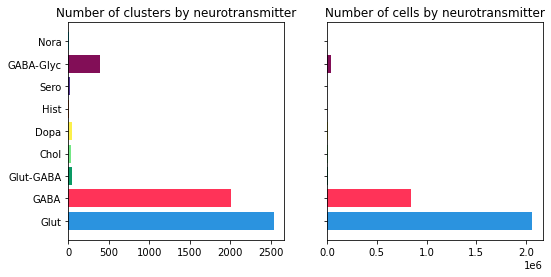

In [18]:
bar_plot_by_level_and_type(term_with_counts,'neurotransmitter')

#### Division cluster and cell counts
Division "3 PAL-sAMY-TH-HY-MB-HB neuronal" contains the largest number of clusters (3871), while division "1 Pallium glutamatergic" contains the largest number of cells (> 1.4 million).

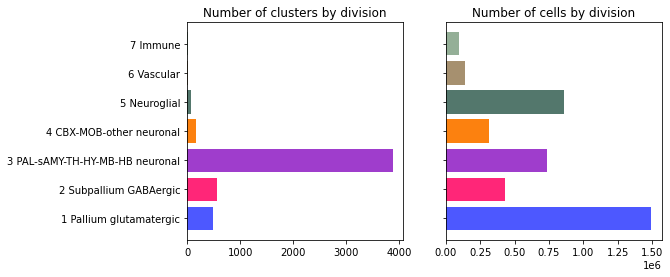

In [19]:
bar_plot_by_level_and_type(term_with_counts,'division')

#### Class level cluster and cell counts
Class "16 MB Glut" contains the largest number of clusters (>600), while class "01 IT-ET Glut" contains the largest number of cells (>1.0 million).

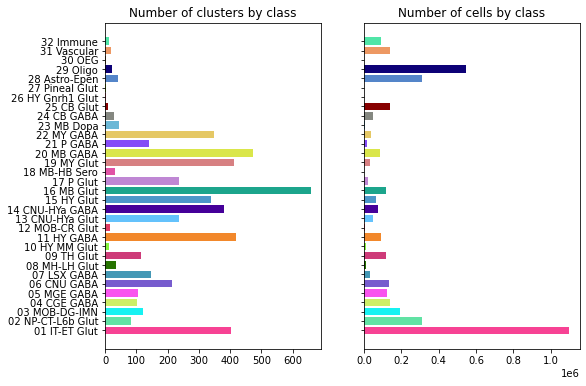

In [20]:
bar_plot_by_level_and_type(term_with_counts,'class',8.5,6)

### Visualizing cluster and term distributions

We can explore the relationship and distribution of clusters between term sets by creating a pivot table using pandas groupby fuunction. Each row of the resulting dataframe represents a cluster, each column represents a term set and the value in the table is the name of the term that has been associated with the cluster for that specific term set.

In [21]:
pivot = membership.groupby(['cluster_alias','cluster_annotation_term_set_name'])['cluster_annotation_term_name'].first().unstack()
pivot = pivot[term_set['name']] # order columns
pivot

cluster_annotation_term_set_name,neurotransmitter,division,class,subclass,supertype,cluster
cluster_alias,,,,,,
1,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0081 L2 IT PPP-APr Glut_3,0327 L2 IT PPP-APr Glut_3
2,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0081 L2 IT PPP-APr Glut_3,0328 L2 IT PPP-APr Glut_3
3,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0080 L2 IT PPP-APr Glut_2,0323 L2 IT PPP-APr Glut_2
4,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0080 L2 IT PPP-APr Glut_2,0324 L2 IT PPP-APr Glut_2
5,Glut,1 Pallium glutamatergic,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0080 L2 IT PPP-APr Glut_2,0326 L2 IT PPP-APr Glut_2
...,...,...,...,...,...,...
5406,Glut,3 PAL-sAMY-TH-HY-MB-HB neuronal,19 MY Glut,180 MB/HB Lhx1 Glut,0740 MB/HB Lhx1 Glut_1,3711 MB/HB Lhx1 Glut_1
5407,Glut,3 PAL-sAMY-TH-HY-MB-HB neuronal,19 MY Glut,180 MB/HB Lhx1 Glut,0741 MB/HB Lhx1 Glut_2,3722 MB/HB Lhx1 Glut_2
5408,Glut,3 PAL-sAMY-TH-HY-MB-HB neuronal,16 MB Glut,158 PRC-PAG Tcf7l2 Glut,0636 PRC-PAG Tcf7l2 Glut_2,2911 PRC-PAG Tcf7l2 Glut_2


We can also obtain a cluster annotation color pivot table in the same way.

In [22]:
color = membership.groupby(['cluster_alias','cluster_annotation_term_set_name'])['color_hex_triplet'].first().unstack().fillna('#f9f9f9')
color = color[term_set['name']] # order columns
color.columns = ['%s_color' % x for x in color.columns]
color

,neurotransmitter_color,division_color,class_color,subclass_color,supertype_color,cluster_color
cluster_alias,,,,,,
1,#2B93DF,#4D58FF,#f74294,#0F6632,#266DFF,#26FF8C
2,#2B93DF,#4D58FF,#f74294,#0F6632,#266DFF,#280099
3,#2B93DF,#4D58FF,#f74294,#0F6632,#002BCC,#5CCCA0
4,#2B93DF,#4D58FF,#f74294,#0F6632,#002BCC,#CC6D1F
5,#2B93DF,#4D58FF,#f74294,#0F6632,#002BCC,#FF8E26
...,...,...,...,...,...,...
5406,#2B93DF,#9F3DCC,#D78082,#FF000F,#FF2689,#E22600
5407,#2B93DF,#9F3DCC,#D78082,#FF000F,#0F2466,#5D0099
5408,#2B93DF,#9F3DCC,#1ca58c,#30660F,#660007,#5CCCA4


For convenience, we can cache this view for later reuse.

In [23]:
if cache_views :
    
    file = os.path.join( view_directory, 'cluster_to_cluster_annotation_membership_pivoted.csv')
    pivot.to_csv( file )
    
    file = os.path.join( view_directory, 'cluster_to_cluster_annotation_membership_color.csv')
    color.to_csv( file )

For a given pair of term sets A and B, define a function *distribution* that creates a cluster count table where the rows are terms in term set A, columns are terms in term set B and the table values being the number of clusters that is shared between the terms. 

In [24]:
def distribution( A, B ) :
    
    AxB = pivot.groupby([A,B])[['cluster']].count()
    AxB.columns = ['number_of_clusters']
    AxB = AxB.unstack().fillna(0)

    B_names = [x[1] for x in list(AxB.columns)]
    pred = (term['cluster_annotation_term_set_name'] == B)
    term_by_name = term[pred].set_index('name')
    B_colors = term_by_name.loc[B_names,'color_hex_triplet']
    
    return AxB, B_names, B_colors

Function *stacked_bar_distribution* takes the results of *distribution* as input to create distribution stacked bar plot.


In [25]:
def stacked_bar_distribution( AxB, B_names, B_colors, fig_width = 6, fig_height = 6 ) :

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    bottom = np.zeros(len(AxB))

    for i, col in enumerate(AxB.columns):
        ax.barh(AxB.index, AxB[col], left=bottom, label=col[1], color=B_colors[i])
        bottom += np.array(AxB[col])

    ax.set_title('Distribution of %s in each %s' % (AxB.columns.names[1],AxB.index.name))
    ax.legend()

    plt.show()

#### Distribution of neurotransmitter clusters in each division

For the stacked bar plot below, it can observed that most divisions are composed of mixed neurotransmitter cluster types with the exception of divison "1 Pallium glutamatergic" which contains only glutamatergic clusters.

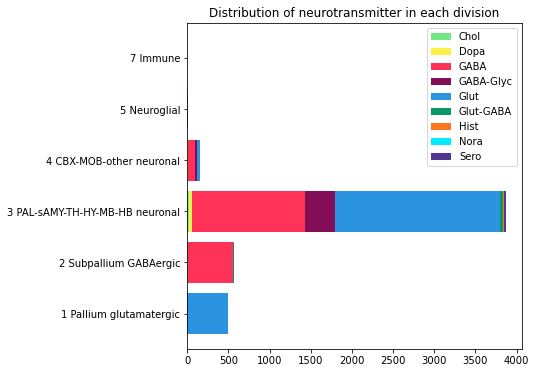

In [26]:
AxB, B_names, B_colors = distribution( 'division', 'neurotransmitter' )
stacked_bar_distribution(AxB,B_names,B_colors,6,6)

#### Distribution of neurotransmitter clusters in each class

At the next level of classification, around 50% of the classes are have a single neurotransmitter identity and remaining 50% are of mixed types.

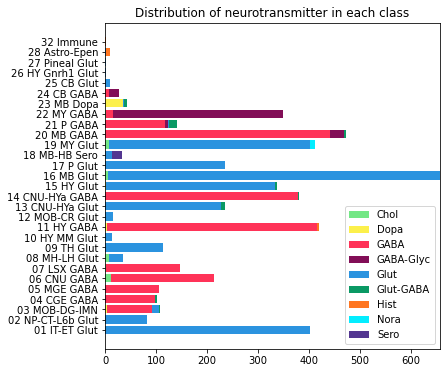

In [27]:
AxB, B_names, B_colors = distribution( 'class', 'neurotransmitter' )
stacked_bar_distribution(AxB,B_names,B_colors,6,6)

#### Distribution of division clusters in each class

While clusters in a class mostly come from one division there a couple of exceptions. For example, class "03 MOB-DG-IMN" is composed of both "1 Pallium glutamatergic" and "4 CBX-MOB-other neuronal" division clusters.

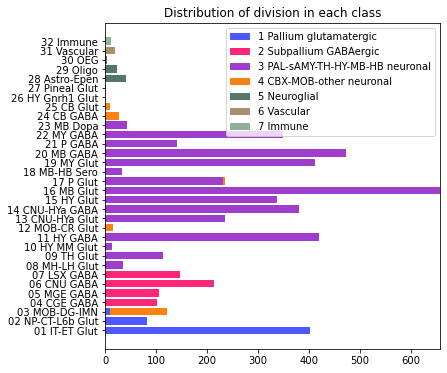

In [28]:
AxB, B_names, B_colors = distribution( 'class', 'division' )
stacked_bar_distribution(AxB,B_names,B_colors,6,6)

### Visualizing the mouse whole brain taxonomy

Term sets: class, subclass, supertype and cluster forms a four level mouse whole brain taxonomy. We can visualized the taxonomy as a sunburst diagram that shows the single inheritance hierarchy through a series of rings, that are sliced for each annotation term. Each ring corresponds to a level in the hierarchy. We have ordered the rings so that the class level is the outer most ring so that we can add in labels. Rings are sliced up and divided based on their hierarchical relationship to the parent slice. The angle of each slice is proportional to the number of clusters belonging to the term.

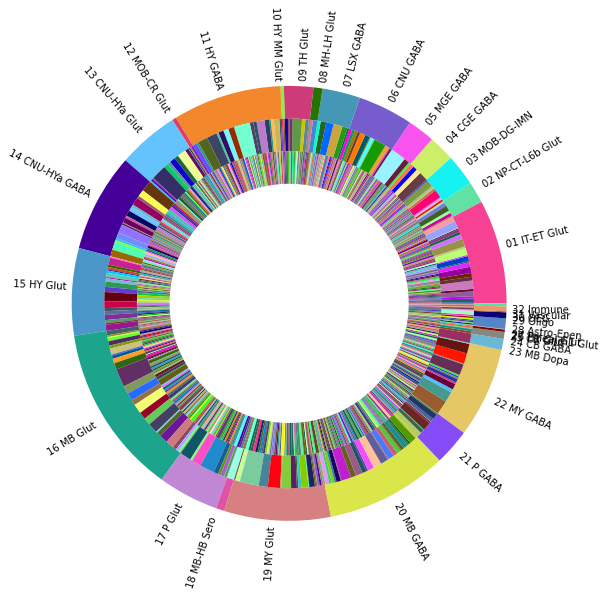

In [29]:
levels = ['class','subclass','supertype']
df = {}

for lvl in levels :
    pred = term_with_counts['cluster_annotation_term_set_name'] == lvl
    df[lvl] = term_with_counts[pred]
    df[lvl] = df[lvl].sort_values(['parent_term_label','label'])

fig, ax = plt.subplots()
fig.set_size_inches(10,10)
size = 0.15

for i, lvl in enumerate(levels) :
    
    if lvl == 'class' :
        ax.pie(df[lvl]['number_of_clusters'], colors=df[lvl]['color_hex_triplet'],
               labels = df[lvl]['name'], rotatelabels=True, labeldistance=1.025,
               radius=1, wedgeprops=dict(width=size, edgecolor=None),startangle=0)
    else :
        ax.pie(df[lvl]['number_of_clusters'], colors=df[lvl]['color_hex_triplet'],
           radius=1-i*size, wedgeprops=dict(width=size, edgecolor=None),startangle=0)


plt.show()